In [2]:
# ETL1のファイルを読み込む
import struct
from PIL import Image, ImageEnhance
import glob, os

# 出力ディレクトリー
outdir = "png-etl1/"
if not os.path.exists(outdir): os.mkdir(outdir)

# ETL1ディレクトリ以下のファイルを処理する
files = glob.glob("ETL1/*")
for fname in files:
    if fname == "ETL1/ETL1INFO": continue #情報ファイルは飛ばす
    print(fname)
    # ETL1のデータファイルを開く
    f = open(fname, 'rb')
    f.seek(0)
    while True:
        # メタデータ＋画像データの組を1つずつ読む
        s = f.read(2052)
        if not s: break
        # バイナリデータなのでPythonが理解できるように抽出
        r = struct.unpack('>H2sH6BI4H4B4x2016s4x', s)
        code_ascii = r[1]
        code_jis = r[3]
        # 画像データとして取り出す
        iF = Image.frombytes('F', (64, 63), r[18], 'bit', 4)
        iP = iF.convert('L')
        # 画像を鮮明にして保存
        dir = outdir + "/" + str(code_jis)
        if not os.path.exists(dir): os.mkdir(dir)
        fn = "{0:02x}-{1:02x}-{2:04x}.png".format(code_jis, r[0], r[2])
        fullpath = dir + "/" + fn
        if os.path.exists(fullpath): continue
        enhancer = ImageEnhance.Brightness(iP)
        iE = enhancer.enhance(16)
        iE.save(fullpath, 'PNG')
print("ok")




ETL1/ETL1C_08
ETL1/ETL1C_01
ETL1/ETL1C_06
ETL1/ETL1C_07
ETL1/ETL1C_09
ETL1/ETL1C_13
ETL1/ETL1C_12
ETL1/ETL1C_05
ETL1/ETL1C_02
ETL1/ETL1C_03
ETL1/ETL1C_04
ETL1/ETL1C_10
ETL1/ETL1C_11
ok


dir= ./png-etl1/177
dir= ./png-etl1/178
dir= ./png-etl1/179
dir= ./png-etl1/180
dir= ./png-etl1/181
dir= ./png-etl1/182
dir= ./png-etl1/183
dir= ./png-etl1/184
dir= ./png-etl1/185
dir= ./png-etl1/186
dir= ./png-etl1/187
dir= ./png-etl1/188
dir= ./png-etl1/189
dir= ./png-etl1/190
dir= ./png-etl1/191
dir= ./png-etl1/192
dir= ./png-etl1/193
dir= ./png-etl1/194
dir= ./png-etl1/195
dir= ./png-etl1/196
dir= ./png-etl1/197
dir= ./png-etl1/198
dir= ./png-etl1/199
dir= ./png-etl1/200
dir= ./png-etl1/201
dir= ./png-etl1/202
dir= ./png-etl1/203
dir= ./png-etl1/204
dir= ./png-etl1/205
dir= ./png-etl1/206
dir= ./png-etl1/207
dir= ./png-etl1/208
dir= ./png-etl1/209
dir= ./png-etl1/210
dir= ./png-etl1/211
dir= ./png-etl1/212
dir= ./png-etl1/213
dir= ./png-etl1/214
dir= ./png-etl1/215
dir= ./png-etl1/216
dir= ./png-etl1/217
dir= ./png-etl1/218
dir= ./png-etl1/219
dir= ./png-etl1/220
dir= ./png-etl1/166
dir= ./png-etl1/221


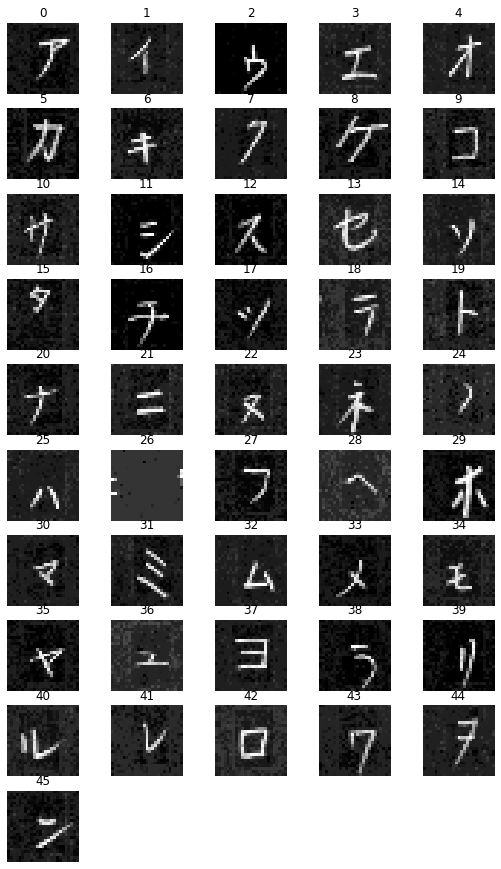

ok


In [4]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle

# 保存席や画像サイズの指定
out_dir = "./png-etl1" #画像データがあるディレクトリ
im_size = 25 #画像のサイズ
save_file = out_dir + "/katakana.pickle" #保存先
plt.figure(figsize=(9, 17)) #出力サイズを大きくする

# カタカナの入っているディレクトリから画像を取得
kanadir = list(range(177, 220+1))
kanadir.append(166) # ヲ
kanadir.append(221) # ン
result = []
for i, code in enumerate(kanadir):
    img_dir = out_dir + "/" + str(code)
    fs = glob.glob(img_dir + "/*")
    print("dir=", img_dir)
    # 画像を読み込んでグレースケールに変換してリサイズする
    for j, f in enumerate(fs):
        img = cv2.imread(f)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img_gray, (im_size, im_size))
        result.append([i, img])
        # Jupyter Notebookで画像を出力
        if j == 3:
            plt.subplot(11, 5, i + 1)
            plt.axis("off")
            plt.title(str(i))
            plt.imshow(img, cmap='gray')

# ラベルとデータの画像を保存
pickle.dump(result, open(save_file, "wb"))
plt.show()
print("ok")


In [6]:
import numpy as np
import cv2, pickle
from sklearn.model_selection import train_test_split
import keras

# データファイルと画像サイズの指定
data_file = "./png-etl1/katakana.pickle"
im_size = 25
in_size = im_size * im_size
out_size = 46 #ア〜ンまでの文字の数

# 保存した画像データ一覧を読み込む
data = pickle.load(open(data_file, "rb"))

# 画像データを0-1の範囲に直す
y = []
x = []
for d in data:
    (num, img) = d
    img = img.reshape(-1).astype('float') / 255
    y.append(keras.utils.to_categorical(num, out_size))
    x.append(img)
x = np.array(x)
y = np.array(y)

# 学習用とテスト用に分離する
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size = 0.2, train_size = 0.8, shuffle = True)

# モデル構造を定義
Dense = keras.layers.Dense
model = keras.models.Sequential()
model.add(Dense(512, activation='relu', input_shape=(in_size,)))
model.add(Dense(out_size, activation='softmax'))

# モデルを構築して学習を実行
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',metrics=['accuracy'])
model.fit(x_train, y_train, 
    batch_size=20, epochs=50, verbose=1,
    validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=1)
print('正解率=', score[1], 'loss=', score[0])


Epoch 1/50
2766/2766 [==============================] - 5s 2ms/step - loss: 2.2200 - accuracy: 0.4369 - val_loss: 1.3769 - val_accuracy: 0.6307
Epoch 2/50
2766/2766 [==============================] - 5s 2ms/step - loss: 1.0156 - accuracy: 0.7367 - val_loss: 0.8082 - val_accuracy: 0.7906
Epoch 3/50
2766/2766 [==============================] - 5s 2ms/step - loss: 0.6700 - accuracy: 0.8244 - val_loss: 0.6603 - val_accuracy: 0.8193
Epoch 4/50
2766/2766 [==============================] - 5s 2ms/step - loss: 0.5172 - accuracy: 0.8619 - val_loss: 0.5821 - val_accuracy: 0.8392
Epoch 5/50
2766/2766 [==============================] - 5s 2ms/step - loss: 0.4263 - accuracy: 0.8860 - val_loss: 0.5062 - val_accuracy: 0.8586
Epoch 6/50
2766/2766 [==============================] - 5s 2ms/step - loss: 0.3606 - accuracy: 0.9024 - val_loss: 0.4605 - val_accuracy: 0.8718
Epoch 7/50
2766/2766 [==============================] - 5s 2ms/step - loss: 0.3130 - accuracy: 0.9155 - val_loss: 0.4719 - val_accuracy:

In [ ]:
import numpy as np
import cv2, pickle
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras.datasets import mnist
import matplotlib.pyplot as plt

# データファイルと画像サイズの指定
data_file = "./png-etl1/katakana.pickle"
im_size = 25
out_size = 46 #ア-ンまでの文字の数
im_color = 1 #画像の色空間／グレースケール
in_shape = (im_size, im_size, im_color)

# カタカナ画像のデータセットを読み込む
data = pickle.load(open(data_file, "rb"))

# 画像データを変形して0-1の範囲に直す
y = []
x = []
for d in data:
    (num, img) = d
    img = img.astype('float').reshape(im_size, im_size, im_color) / 255
    y.append(keras.utils.to_categorical(num, out_size))
    x.append(y)

# 学習用とテスト用に分離する
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size = 0.2, train_size = 0.8, shuffle = True)

# CNNモデル構造を定義
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=in_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(out_size, activation='softmax'))
model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(),
    metrics=['accuracy'])

# 学習を実行して評価
hist = model.fit(x_train, y_train, batch_size=128, epochs=1, verbose=1, validation_data=(x_test, y_test))

# モデルを評価
score = model.evaliate(x_test, y_test, verbose=1)
print('正解率=', score[1], 'loss=', score[0])

# 学習の様子をグラフへ描画
# 正解率の推移をプロット
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# ロスの推移をプロット
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

